In [1]:
import json
import os
from collections import defaultdict

performance_dir = "performance--q2-de_1"
noop_performance_dir = "performance--q2-noopt_1"
detection_dir = "detection--q2-de_1"
sort_dir = "sort--q2-de_1"
noop_sort_dir = "sort--q2-noopt_1"


def filter_cars(detections):
    return [d for d in detections if d[-1] == 2.0]


def extract_pairs(sort_results):
    pairs = []
    for detection in sort_results.values():
        if detection:  # make sure detection is not empty
            pairs.append((detection['object_id'], tuple(detection['detection_id'])))
    return pairs


def calculate_matches(current_sort_results, next_sort_results, current_noop_results, next_noop_results):
    # Convert the results into lists of (object_id, detection_id) tuples
    current_sort_pairs = extract_pairs(current_sort_results)
    next_sort_pairs = extract_pairs(next_sort_results)
    current_noop_pairs = extract_pairs(current_noop_results)
    next_noop_pairs = extract_pairs(next_noop_results)

    # Create dictionaries to map detection_ids to object_ids for current and next frames
    current_sort_dict = {det_id: obj_id for obj_id, det_id in current_sort_pairs}
    next_sort_dict = {det_id: obj_id for obj_id, det_id in next_sort_pairs}
    current_noop_dict = {det_id: obj_id for obj_id, det_id in current_noop_pairs}
    next_noop_dict = {det_id: obj_id for obj_id, det_id in next_noop_pairs}
    TP = FP = FN = 0  # Initialize counts

    # Calculate matches
    for current_det_id, current_obj_id in current_sort_dict.items():
        # Check if current detection id is in both current frame sort and noop
        if current_det_id in current_noop_dict:
            # Check if the next detection id for current detection id is the same in sort and noop
            for next_det_id, next_obj_id in next_sort_dict.items():
                if next_obj_id == current_obj_id:
                    if next_det_id in next_noop_dict:
                        if next_noop_dict[next_det_id] == current_noop_dict[current_det_id]:
                            TP += 1  # True positive: detection id is correctly tracked from current to next
                        else:
                            FN += 1
        else:
            FP += 1  # False positive: detection id is tracked in sort but not in noop

    # As before, TN is not calculated as it's not defined in this context
    return TP, FP, FN

performance_files = sorted(os.listdir(performance_dir))
noop_performance_files = sorted(os.listdir(noop_performance_dir))
sort_files = sorted(os.listdir(sort_dir))
noop_sort_files = sorted(os.listdir(noop_sort_dir))
# detection_files = sorted(os.listdir(detection_dir))

skip_map = defaultdict(lambda: {'count': 0, 'tp': 0, 'fp':0, 'fn':0, 'de_strongsort_time': 0, 'total_strongsort_time': 0})

for i in range(len(performance_files)):
    with open(os.path.join(performance_dir, performance_files[i])) as f:
        performance = json.load(f)
    with open(os.path.join(noop_performance_dir, noop_performance_files[i])) as f:
        noop_performance = json.load(f)
    with open(os.path.join(sort_dir, sort_files[i])) as f:
        sort_result = json.load(f)
    with open(os.path.join(noop_sort_dir, noop_sort_files[i])) as f:
        noop_sort_result = json.load(f)
    # with open(os.path.join(detection_dir, detection_files[i])) as f:
    #     all_detections = json.load(f)

    detection_estimation_benchmark = performance[5]["benchmark"]
    strong_sort_benchmark = noop_performance[5]["benchmark"]
    # import code; code.interact(local=dict(globals(), **locals()))
    skip_track = detection_estimation_benchmark.get("skip_track", [])

    for track in skip_track:
        current_f, next_f, process_time = track
        skip_map[next_f-current_f-1]["count"] += 1
        skip_map[next_f-current_f-1]["de_strongsort_time"] = process_time + strong_sort_benchmark["frame_process_time"][current_f]
        # Assuming sort_result and noop_sort_result are your pipeline results    
        TP, FP, FN = calculate_matches(sort_result[current_f],
                                       sort_result[next_f],
                                       noop_sort_result[current_f],
                                       noop_sort_result[next_f])
        skip_map[next_f-current_f-1]["tp"] += TP
        skip_map[next_f-current_f-1]["fp"] += FP
        skip_map[next_f-current_f-1]["fn"] += FN
        overskip_counted = False
        for f in range(current_f, next_f):
            skip_map[next_f-current_f-1]["total_strongsort_time"] += strong_sort_benchmark["frame_process_time"][f]
    
skip_map = dict(skip_map)

# calculate f1 score for the skip_map
def calculate_f1(TP, FP, FN):
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1
for skip in skip_map:
    skip_map[skip]["f1"] = calculate_f1(skip_map[skip]["tp"], skip_map[skip]["fp"], skip_map[skip]["fn"])
print(skip_map)

{0: {'count': 8273, 'tp': 11827, 'fp': 0, 'fn': 753, 'de_strongsort_time': 0.040726423263549805, 'total_strongsort_time': 335.37794733047485, 'f1': 0.9691481951899046}, 2: {'count': 126, 'tp': 104, 'fp': 0, 'fn': 18, 'de_strongsort_time': 0.05101346969604492, 'total_strongsort_time': 16.704185485839844, 'f1': 0.9203539823008848}, 1: {'count': 209, 'tp': 304, 'fp': 0, 'fn': 29, 'de_strongsort_time': 0.06440067291259766, 'total_strongsort_time': 18.682737112045288, 'f1': 0.9544740973312402}, 3: {'count': 49, 'tp': 32, 'fp': 0, 'fn': 10, 'de_strongsort_time': 0.05177640914916992, 'total_strongsort_time': 7.796563625335693, 'f1': 0.8648648648648648}, 6: {'count': 20, 'tp': 5, 'fp': 0, 'fn': 2, 'de_strongsort_time': 0.10401797294616699, 'total_strongsort_time': 6.007238149642944, 'f1': 0.8333333333333333}, 9: {'count': 13, 'tp': 6, 'fp': 0, 'fn': 0, 'de_strongsort_time': 0.034673452377319336, 'total_strongsort_time': 4.9739625453948975, 'f1': 1.0}, 4: {'count': 64, 'tp': 44, 'fp': 0, 'fn': 

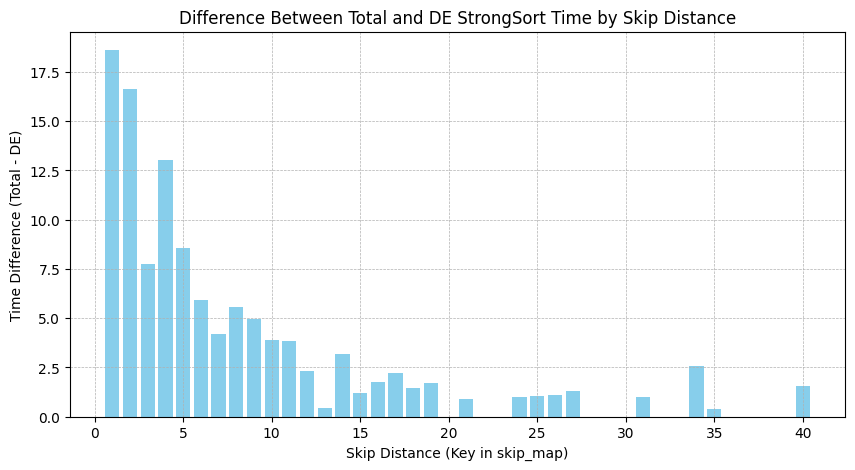

In [2]:
import matplotlib.pyplot as plt

# Assuming skip_map is the dictionary you have after running the above code
# Prepare the data for plotting
x_values = sorted(skip_map.keys())[1:]  # Sorting the keys to ensure the plot is ordered
y_values = [skip_map[k]['total_strongsort_time'] - skip_map[k]['de_strongsort_time'] for k in x_values]

# Plotting the data
plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
plt.bar(x_values, y_values, color='skyblue')  # Create a bar plot

# Add titles and labels
plt.title('Difference Between Total and DE StrongSort Time by Skip Distance')
plt.xlabel('Skip Distance (Key in skip_map)')
plt.ylabel('Time Difference (Total - DE)')

# Show grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()


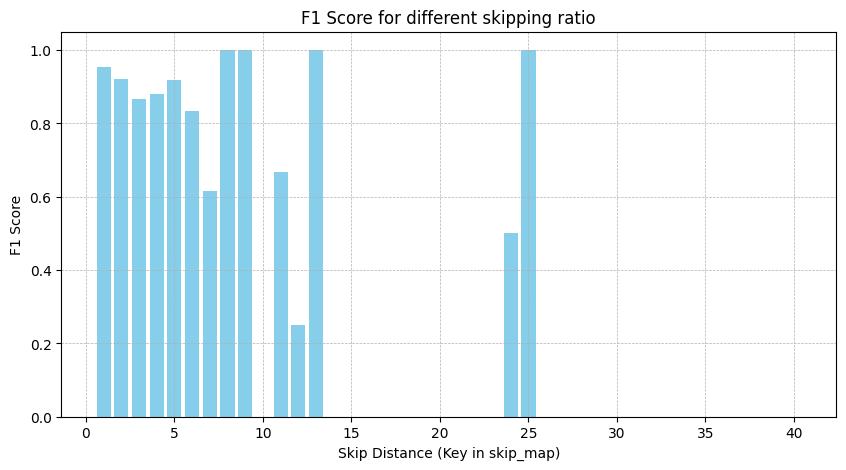

In [3]:
x_values = sorted(skip_map.keys())[1:]  # Sorting the keys to ensure the plot is ordered
y_values = [skip_map[k]['f1'] for k in x_values]

# Plotting the data
plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
plt.bar(x_values, y_values, color='skyblue')  # Create a bar plot

# Add titles and labels
plt.title('F1 Score for different skipping ratio')
plt.xlabel('Skip Distance (Key in skip_map)')
plt.ylabel('F1 Score')

# Show grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()